# Lesson 1 Pratice Notebook
This notebook contains pratice code generated while going through Lesson 1 of FastAI course.
### Intro the dataset
* The Dog vs Cats dataset consists of lebelled imaged of dogs and cats.
* Total number of training examples, $m_{train}$ = 25,000
* Total number of test examples, $m_{test}$ = 12,5000.
* As of 2013, best performing machine learning algorithms had about 80% accuracy.

In order to get set up, let's configure this notebook. This will make sure that external modules are automatically reloaded if any changes are made to the underlying code, and that plotting and fastai functionality is available to us.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Let's also make sure that NVidia GPU is set up and ready to use.

In [4]:
print(torch.cuda.is_available())
# this is optional
print(torch.backends.cudnn.enabled)

True
True


Perfect! Finally, let's set some global variables, such as the path to the dataset files and the image size (more details on this later). 

In [5]:
PATH = "data/dogscats/"
sz = 224

### A note on dataset organization for ML/DL
One of the major takeaways from this lesson was that typically the datasets for ML/DL are split as follows:

* Train: This is our training dataset.

* Valid: This is validation dataset, used for hyperparamter optimization.

* Test: This the final test set unseen by the model.

One can also create a parallel version of the above for just setting things up, just to make sure that everything is working fine. We can call this sample dataset.

## A quick look at the dataset
Let's take a look at the dataset and also see if our directory structure is organized properly.

In [6]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [7]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [8]:
files = os.listdir(f'{PATH}valid/cats')
files[:10]

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg',
 'cat.7585.jpg',
 'cat.3808.jpg',
 'cat.3052.jpg',
 'cat.1616.jpg',
 'cat.7850.jpg']

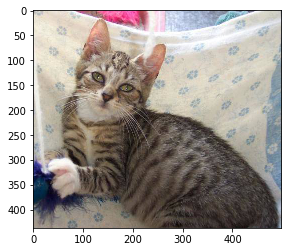

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [10]:
img.shape

(437, 499, 3)

In [11]:
img[:4, :4]

array([[[211, 211, 219],
        [210, 211, 216],
        [208, 207, 213],
        [202, 201, 206]],

       [[200, 201, 206],
        [199, 198, 204],
        [196, 195, 200],
        [193, 192, 197]],

       [[193, 192, 197],
        [189, 188, 193],
        [184, 183, 188],
        [185, 185, 187]],

       [[197, 195, 198],
        [189, 187, 190],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

## First Model
Main features:
* A pre-trained model, trained on ImageNet
* A convolutional neural network, called resnet 34

Let's train!

In [12]:
arch = resnet34
# load in data
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
# create model
learn = ConvLearner.pretrained(arch, data, precompute=True)

**A note on pre-computed activations**
Based on a quick look around on what does it mean to have precomputer activations for your neural network, I think that this has to do with how transfer learning is basically done. We have a model that is already trained, especially a model from a large dataset (such as ImageNet). We then 'freeze' let's say N layers, which means that we no longer wish to train them anymore and would like to keep there parameters as such. We can then output acttivations form the last frozen layer and save them as part of the model. We can then add one or more new layers that are trained on a new dataset.

In [13]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
data.classes

['cats', 'dogs']

In [15]:
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.042689   0.029007   0.985352  
    1      0.039922   0.027095   0.989746                     



[0.027095135, 0.98974609375]

Now that the we have fit the model, we can see that it's accuracy (which I assume is based on cross-validation) is ~99%. Let's take a look at some example of predictions.

In [23]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [24]:
log_preds[:10]

array([[ -0.00007,  -9.54852],
       [ -0.00043,  -7.74858],
       [ -0.00051,  -7.57608],
       [ -0.00076,  -7.18693],
       [ -0.0002 ,  -8.51484],
       [ -0.00016,  -8.73456],
       [ -0.0005 ,  -7.60738],
       [ -0.00003, -10.56727],
       [ -0.00132,  -6.63329],
       [ -0.00014,  -8.86822]], dtype=float32)

In [25]:
# let's get prediction, expressed as 0 or 1 for if the image is of a cat or a dog respectively. 
preds = np.argmax(log_preds, axis=1)
# let's also convert log values into probabilities
probs = np.exp(log_preds[:, 1])
print(probs[:10])

[0.00007 0.00043 0.00051 0.00076 0.0002  0.00016 0.0005  0.00003 0.00132 0.00014]


In order to facilitate looking at different images from the dataset and corresponding predictions. let's create some utility functions for plotting. 

In [50]:
def rand_by_mask(mask):
    """
    Selects and returns indices of four random examples, where value of mask is True
    
    Parameters
    ==========
    mask : numpy.ndarray
        Boolean array of correct or incorrect predictions
    
    Return
    ======
    choices : numpy.ndarray
        Array of four indices, where value in mask array is True 
    """
    choices  = np.random.choice(np.where(mask)[0], 4, replace=False)
    return choices

def rand_by_correct(masks, is_correct):
    """
    Applies selection mask (is_coorect) to boolean array of correct and incorrect prediction.
    
    Parameters
    ==========
    masks : numpy.ndarray
        Array of boolean masks, corresponding to correct and incorrect predictions
    is_correct : bool
        Random examples with this boolean mask will be picked
    
    Return
    ======
    selected_examples : numpy.ndarray
        Array of indices, where prediction result corresponds to is_correct
    """
    is_correct_array = (masks == is_correct)
    selected_examples = rand_by_mask(is_correct_array)
    return selected_examples

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

def load_img_id(ds, idx): 
    """
    Genrate numpy array for the images in the dataset
    """
    
    image_arrays = np.array(PIL.Image.open(PATH+ds.fnames[idx]))
    return image_arrays

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
        
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


In [57]:
# Let's generate an array with boolean mask for every example in the training data, where boolean
# corresponds to whether or not a correct prediction was made 
trn_pred_bool_masks = (preds == data.val_y)
# Let's use this array to get examples in different categories
some_correct_predictions = rand_by_correct(trn_pred_bool_masks, True)
some_wrong_predictions = rand_by_correct(trn_pred_bool_masks, False)
most_correct_cats = most_by_correct(0, True), "Most correct cats"
most_correct_dogs = most_by_correct(1, True), "Most correct dogs"
most_incorrect_cats = most_by_correct(0, False), "Most correct cats"
most_incorrect_dogs = most_by_correct(1, False), "Most correct dogs"
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]

#plot_val_with_title(rand_by_correct(True), "Correct")

Correct


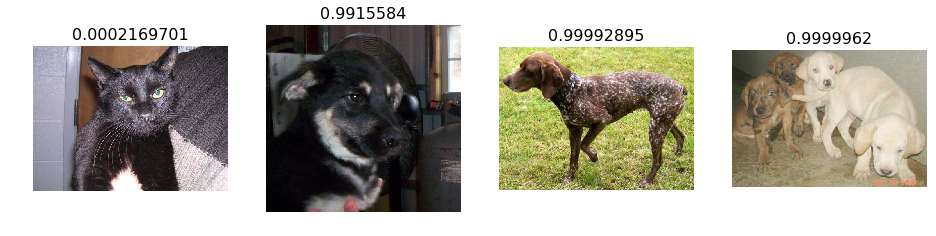

In [58]:
plot_val_with_title(some_correct_predictions, "Correct")

Incorrect


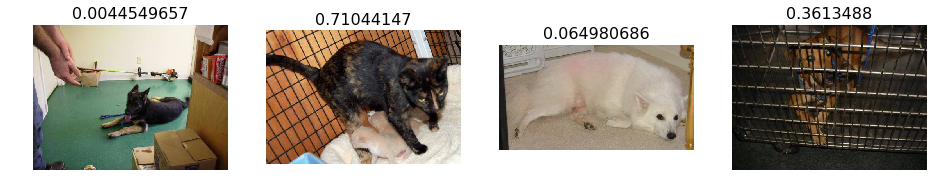

In [59]:
plot_val_with_title(some_wrong_predictions, "Incorrect")

## Choosing a learning rate

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▎ | 301/360 [00:05<00:01, 53.74it/s, loss=0.41] 


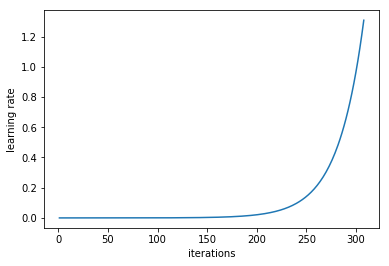

In [34]:
learn.sched.plot_lr()

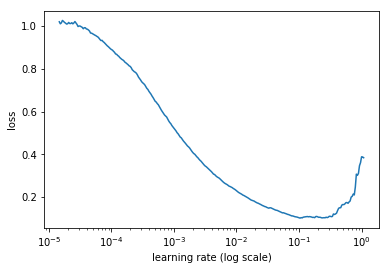

In [35]:
learn.sched.plot()

### The learning schedule
The main idea here is that the learning drops as we get closer and closer to the minimum of the loss function. However,  some sort of a plateau reaches eventually  